In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.cosmology import z_at_value, FlatLambdaCDM, wCDM

import camb

from tqdm import tqdm

from utils import read_cosmo_params, get_path_lightcone, get_path_redshifts

from BornRaytrace.bornraytrace import lensing

### Try ray tracing with BornRayTrace

In [2]:
sim = 1

path_info = '/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv'
path_sims = '/n17data/sguerrini/GowerStreetSims/'

cosmo_params = read_cosmo_params(path_info, sim)
cosmo_params

{'h': array([0.66736206]),
 'Omega_m': array([0.29004048]),
 'Omega_b': array([0.05021784]),
 'sigma_8': array([0.7657514]),
 'n_s': array([0.94965154]),
 'w': array([-1.00894147]),
 'm_nu': array([0.06]),
 'A_s': array([2.20263889e-09])}

In [3]:
def make_map(sim, cosmo_params, nside):
    #Recover cosmological parameters
    H0 = cosmo_params['h'][0] * 100 * u.km / u.s / u.Mpc
    Om0 = cosmo_params['Omega_m'][0]
    w0 = cosmo_params['w'][0]

    cosmology = wCDM(H0=H0, Om0=Om0, Ode0=1-Om0, w0=w0)

    #Read redshift information
    path_exist, path = get_path_redshifts(path_sims, sim)
    assert path_exist, f'The path {path} does not exist'

    infos = pd.read_csv(path, sep=",")

    #Get overdensity array
    overdensity_array = []
    z_edges = []

    for step, z_far in tqdm(zip(infos['# Step'], infos['z_far'])):

        path_exist, path = get_path_lightcone(path_sims, sim, step)
        if path_exist:
            density_i = np.load(path) #Number of gals per pixel
            density_i = density_i / np.mean(density_i) - 1 #Overdensity
            if nside < 2048:
                density_i = hp.ud_grade(density_i, nside_out=nside) #Downgrade resolution
            elif nside > 2048:
                raise ValueError('The nside is too high')
            
            overdensity_array.append(density_i)
            z_edges.append(z_far)
        
    z_edges.append(0.0)

    z_edges = np.sort(np.array(z_edges))
    overdensity_array = np.array(overdensity_array[::-1]) #Sort in order to have lower redshifts first

    #Create inputs for BornRaytrace
    comoving_edges = cosmology.comoving_distance(z_edges)
    z_centre = np.array([z_at_value(cosmology.comoving_distance, 0.5*(comoving_edges[i]+comoving_edges[i+1])) for i in range(len(comoving_edges)-1)])

    #Perform kappa lensing
    kappa_lensing = np.copy(overdensity_array)* 0.

    for i in tqdm(np.arange(1, kappa_lensing.shape[0]+1)):
        kappa_lensing[i-1] = lensing.raytrace(
            H0, Om0,
            overdensity_array = overdensity_array[:i].T,
            a_centre =  1./(1.+z_centre[:i]),
            comoving_edges = comoving_edges[:i+1],
        )

    return z_edges, kappa_lensing

    


In [4]:
nside = 512

z_edges, kappa_lensing = make_map(sim, cosmo_params, nside)

100it [05:53,  3.54s/it]
100%|██████████| 77/77 [00:48<00:00,  1.60it/s]


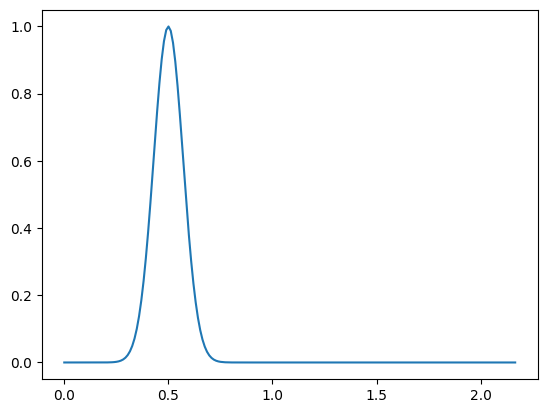

In [5]:
#Load the redshift distribution
z = np.linspace(0., 2.16565, 200)
dndz = np.exp(-(z - 0.5)**2 / 0.1**2)

plt.figure()

plt.plot(z, dndz)

plt.show()

In [6]:
import glass.shells

In [7]:
kappa_bar = np.zeros_like(kappa_lensing[0])

weights = glass.shells.tophat_windows(z_edges)

ngal_tracker = 0

for i, kappa in enumerate(kappa_lensing):
    z_i, dndz_i = glass.shells.restrict(z, dndz, weights[i])
    ngal = np.trapz(dndz_i, z_i)
    ngal_tracker += ngal
    kappa_bar += kappa * ngal

kappa_bar /= np.trapz(dndz, z)

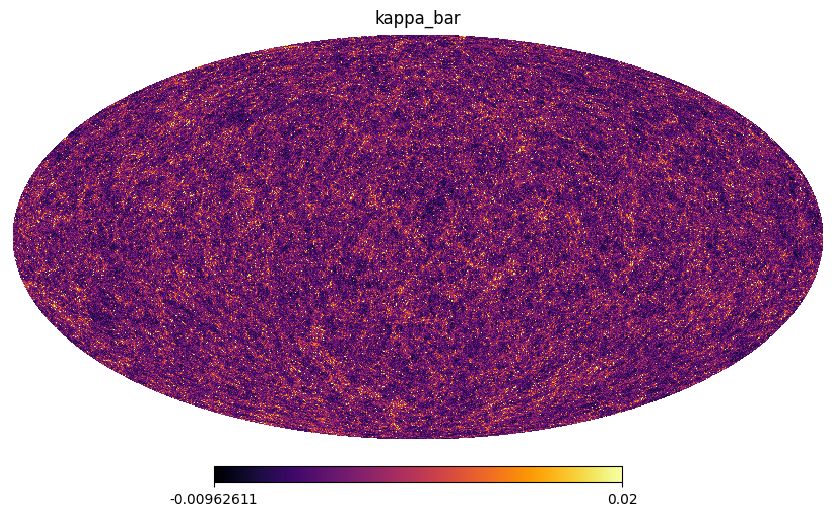

In [15]:
hp.mollview(kappa_bar, title='kappa_bar', cmap='inferno', max=0.02)
plt.show()

In [9]:
np.sum(np.ones_like(kappa_bar)[kappa_bar > 0.02])/hp.nside2npix(nside)

0.0066610972086588545

In [10]:
#Load parameters for the cosmology
h = cosmo_params["h"]
Om = cosmo_params["Omega_m"]
Ob = cosmo_params["Omega_b"]
Oc = Om - Ob
ns = cosmo_params["n_s"]
m_nu = cosmo_params["m_nu"]
w = cosmo_params["w"]
As = cosmo_params["A_s"]

nside=512
lmax = 3*nside

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

#get the angular power spectra of the lensing map
sim_cls = hp.anafast(kappa_bar, pol=True, lmax=lmax, use_pixel_weights=True)

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

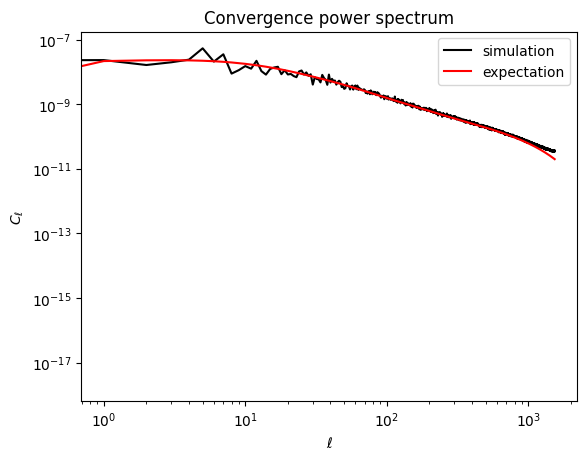

/tmp/ipykernel_1302867/3343583246.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.plot(l, sim_cls/(theory_cls['W1xW1']*pw**2))


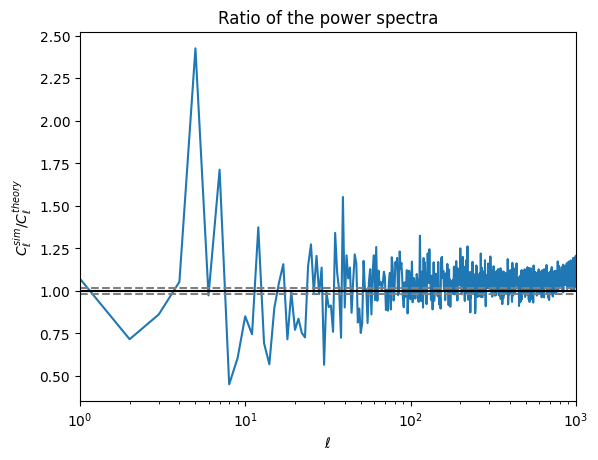

In [13]:
plt.figure()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, sim_cls, label="simulation", c='k')
plt.plot(l, theory_cls['W1xW1']*pw**2, label="expectation", c='r')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Convergence power spectrum")

plt.show()

plt.figure()

plt.plot(l, sim_cls/(theory_cls['W1xW1']*pw**2))
plt.axhline(1, c='k')
plt.axhline(1.02, c='gray', ls='--')
plt.axhline(0.98, c='gray', ls='--')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{sim}/C_\ell^{theory}$")
plt.title("Ratio of the power spectra")

plt.xlim(1, 1e3)

plt.xscale('log')

plt.show()